In [9]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:

drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
main_dir = 'drive/MyDrive/2023JHU/MLMA_EOG/isolated 2/'
os.listdir(main_dir)

['ReadMe', '.DS_Store', '005', '004', '003', '001', '006', '002']

In [15]:
# get data
def get_original_feature_label(path):
    # scale both vertical and horizontal between 0 and 1
    scaler = MinMaxScaler()
    feature = []
    label = []
    for i in os.listdir(path):
        a = pd.read_csv(str(path+i),names=["vertical","horizontal"])
        a = np.array(a)
        a = scaler.fit_transform(a)
        a = np.swapaxes(a,0,1)
        feature.append(a)
        if i.endswith("001.csv"):
            label.append(0)
        elif i.endswith("002.csv"):
            label.append(1)
        elif i.endswith("003.csv"):
            label.append(2)
        elif i.endswith("004.csv"):
            label.append(3)
        elif i.endswith("005.csv"):
            label.append(4)
        elif i.endswith("006.csv"):
            label.append(5)
        elif i.endswith("007.csv"):
            label.append(6)
        elif i.endswith("008.csv"):
            label.append(7)
        elif i.endswith("009.csv"):
            label.append(8)
        elif i.endswith("010.csv"):
            label.append(9)
        elif i.endswith("011.csv"):
            label.append(10)
        elif i.endswith("012.csv"):
            label.append(11)
    
    return feature,label

In [25]:
# Define custom dataset class
class MYDataset(Dataset):
    def __init__(self, feature,label):
      self.feature = []
      self.label = []
      for i in range(len(feature)):
        self.feature.append(feature[i])
        self.label.append(label[i])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        f = self.feature[idx]
        f = f[np.newaxis,:,:]
        l = self.label[idx]
        return f, l


# Split on patient level - User-independent

In [26]:
patient = ["001",'002','003','004','005']
train_feature = []
train_label = []
for i in patient:
    f,l = get_original_feature_label(str(main_dir+i+"/isolated_strokes/"))
    #print(len(f),f[0].shape)
    for x in f:
        train_feature.append(x)         
    for x in l:
        train_label.append(x)
print(len(train_feature))
train_data = MYDataset(train_feature,train_label)
train_dataloader  = DataLoader(train_data, batch_size=16, shuffle=True)


patient = ["006"]
test_feature = []
test_label = []
for i in patient:
    f,l = get_original_feature_label(str(main_dir+i+"/isolated_strokes/"))
    #print(len(f),f[0].shape)
    for x in f:
        test_feature.append(x)         
    for x in l:
        test_label.append(x)
print(len(test_feature))
test_data = MYDataset(test_feature,test_label)
test_dataloader  = DataLoader(test_data, batch_size=16, shuffle=True)

603
121


In [42]:
class classficiation(nn.Module):
    def __init__(self):
        super(classficiation, self).__init__()
        self.encoder = nn.Sequential(
            # your codes here
            nn.Conv2d(1,32,2,stride = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32,momentum=0.99),
            nn.Dropout(p=0.5),
            nn.Conv2d(32,16,1,stride = 1),
            nn.ReLU()   
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(19984,200),
            nn.ReLU(),
            nn.Linear(200,12)
            #nn.Softmax()
        )



    def forward(self, x):
         # your codes here
        encoder = self.encoder(x)
        #print(encoder.shape)
        x = self.classifier(encoder)

        return x 




In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = classficiation()
lr = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 101

#### training
train_loss = []
train_acc = []
test_acc = []
model = model.to(device)
for epoch in range(num_epochs):
      print("running epoch: ", epoch)
      model.train()
      Loss = 0
      train_label = []
      train_ypred = []
      for i, (feature,label) in enumerate(train_dataloader, 0):
        #print(feature.shape)
        optimizer.zero_grad()
        feature = feature.to(device)
        output = model(feature.float())
        ypred = torch.argmax(output.cpu(),dim=1)
        #print(feature.shape,output.shape)
        #print(ypred)
        for j in ypred:
          train_ypred.append(j)
        for j in label:
          train_label.append(j)
        loss = criterion(output,label.to(device))
        loss.backward()
        optimizer.step()
        Loss += loss.item()

      Loss = Loss/(i+1)
      acc = accuracy_score(y_true=train_label, y_pred= train_ypred)
      train_loss.append(Loss)
      train_acc.append(acc)
      print("train loss: ",Loss," train accuracy: ",acc)
      if epoch % 5 == 0:
        print("model saved")
        state_dict = model.state_dict()
        torch.save(state_dict, str("drive/MyDrive/2023JHU/MLMA_EOG/"+'checkpoint/checkpoint_epoch{}.pth'.format(epoch)))


    # Calculate test acc
      with torch.no_grad():
        model.eval()
        label_list = []
        ypred_list = []
        #Loss = 0
        for i, (feature,label) in enumerate(test_dataloader, 0):
          feature = feature.to(device)
          output = model(feature.float())
          #print(output.shape)
          ypred = torch.argmax(output,dim=1)
          for j in ypred.cpu().detach().numpy():
            ypred_list.append(j)
          for l in label.cpu().detach().numpy():
            label_list.append(l)
        test_acc.append(accuracy_score(y_true=label_list, y_pred= ypred_list))
        print("test acc: ", accuracy_score(y_true=label_list, y_pred= ypred_list))

running epoch:  0
train loss:  2.4474313196383024  train accuracy:  0.14262023217247097
model saved
test acc:  0.4462809917355372
running epoch:  1
train loss:  2.26441931097131  train accuracy:  0.4427860696517413
test acc:  0.7024793388429752
running epoch:  2
train loss:  2.0479913510774312  train accuracy:  0.5174129353233831
test acc:  0.7272727272727273
running epoch:  3
train loss:  1.8321570314859088  train accuracy:  0.5754560530679934
test acc:  0.7272727272727273
running epoch:  4
train loss:  1.6279130515299345  train accuracy:  0.6218905472636815
test acc:  0.7768595041322314
running epoch:  5
train loss:  1.446662752251876  train accuracy:  0.6616915422885572
model saved
test acc:  0.768595041322314
running epoch:  6
train loss:  1.2867027756414915  train accuracy:  0.7081260364842454
test acc:  0.8512396694214877
running epoch:  7
train loss:  1.1602737307548523  train accuracy:  0.7280265339966833
test acc:  0.7520661157024794
running epoch:  8
train loss:  1.0489265730

[]

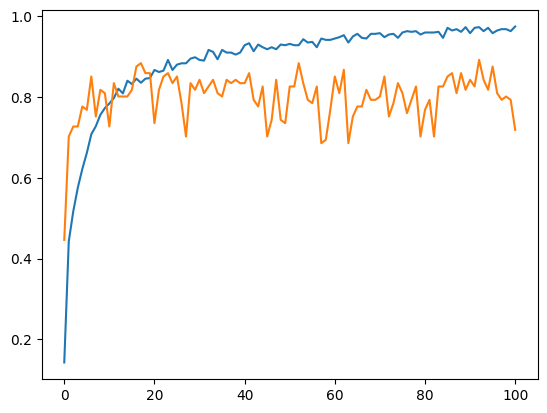

In [56]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs),train_acc,label="train")
plt.plot(range(num_epochs),test_acc,label="test")
plt.plot()